In [1]:
## . . Import the plotting and libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import *
from time import time

## . . For animation
from matplotlib import animation
from IPython.display import HTML, Image

C:\Users\anast\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


<h1><center>LAB 4 - Solving Elliptical PDEs for Steady-state Solutions</center></h1>


## NAME: Anastasia Horne $\hspace{2.5in}$                                 STUDENT NUMBER: 10867499

The purpose of this lab is to get you thinking about solving 2D elliptical PDEs for steady-state problems.  In the first part, you will validate your code by comparing the generated numerical solution against the known analytic version. You will then generate numerical solutions for two scenarios where no analytic solution exists.

**Note: GPGN536 students will use C to reproduce the python codes in the notebook for the computational part.

## Part 1 - Validating Against a Known Solution

You are given a 2D rectanglar region with dimensions of $0\le x \le a$ and $0\le y \le b$ and are looking to compute the interior temperature profile $T(x,y)$. The four sides of the rectangle are held at the following **constant** temperatures:

$$T(x=0,y) = T_1 \tag{1a}$$
$$T(x=a,y) = 0   \tag{1b}$$
$$T(x,y=0) = 0   \tag{1c}$$
$$T(x,y=b) = T_2 \tag{1d}$$

What is the steady-state temperature profile $T(x,y)$ for this system?

Fortunately, you are also given the following theoretical solution to this problem:

$$T(x,y) = \frac{4}{\pi}
\left(
T_2
\sum_{m=0}^{\infty}
\frac{\sin \frac{\pi(2m+1)x}{a}}{2m+1}\frac{\sinh \frac{\pi(2m+1)y}{a}}{\sinh \frac{\pi(2m+1)b}{a}}
+
T_1
\sum_{m=0}^{\infty}
\frac{\sin \frac{\pi(2m+1)y}{b}}{2m+1}\frac{\sinh \frac{\pi(2m+1)(a-x)}{b}}{\sinh \frac{\pi(2m+1)a}{b}}
\right).
\tag{2}
$$

**Q1-1**: Choose a discrete 2D domain on which you will generate numerical solutions. This will require choosing values for dimensions $a$ and $b$.  Note that it is good coding practice to not hard code these values into your solution, but to leave them as variables that can be changed for different geometries. However, without loss of generality, for this problem let's assume that $a=b=1$ for simplicity.

Having chosen your numerical domain, set $T_1 = -1$ and $T_2 = 1$ and then generate a plot of the **analytic** solution given in equation 2. Note that this solution includes two infinite sums. In practice, though, you should only need to sum a finite number of terms. Aim for a value of $m=M$ after which the solution does not change by more than $0.001\%$.

Note that there is a discrepancy of what to do in the corners. For simulation purposes, set the four corner points equal to 0.


In [5]:
#function
def Rect_temp(X, Y, T1, T2, a, b, M):
    #allocate dummy array
    T = np.zeros(X.shape)
    count=0
    #allocate threshold holder
    T_prev = np.zeros(X.shape)
    threshold = 0.001
    #double check boundary conditions
    T[-1   ,:] = T2
    T[:   ,0] = T1
    for m in range(M):
        term1 = (4 / np.pi) * (T2 * (np.sin(np.pi * (2*m + 1) * X / a) / (2*m + 1)) *
                                      (np.sinh(np.pi * (2*m + 1) * Y / a) /
                                       np.sinh(np.pi * (2*m + 1) * b / a)))
        term2 = (4 / np.pi) * (T1 * (np.sin(np.pi * (2*m + 1) * Y / b) / (2*m + 1)) *
                                      (np.sinh(np.pi * (2*m + 1) * (a - X) / b) /
                                       np.sinh(np.pi * (2*m + 1) * a / b)))

        T += term1 + term2
        #double check boundary conditions
        T[0   ,:] = 0
        T[:   ,0] = T1
        T[:, -1] = 0
        T[-1, :] = T2
        count+=1
        # Check for convergence
        if np.max(np.abs(T - T_prev)) < threshold and count>1:
            break
        T_prev = T.copy()
    # Set corners to zero
    T[0, 0] = 0
    T[0, -1] = 0
    T[-1, 0] = 0
    T[-1, -1] = 0



    return T, count

Number of iterations ran: 44


Text(0, 0.5, 'y')

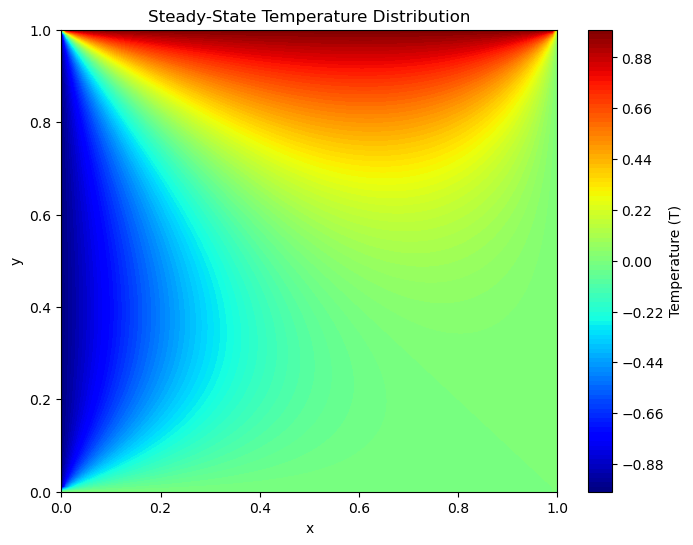

In [6]:
## . . Your answer to Q1-1 goes here
#define terms
a= 1.0
b= 1.0
T1= -1.0
T2= 1.0
M=200

#create solution array
xx= np.linspace(0, a, 100)
yy= np.linspace(0, b, 100)
X, Y= np.meshgrid(xx, yy)



#calc temp profile
T, c= Rect_temp(X, Y, T1, T2, a, b, M)
print("Number of iterations ran:", c)
#plot results
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, T, levels=100, cmap='jet')
plt.colorbar(label='Temperature (T)')
plt.title('Steady-State Temperature Distribution')
plt.xlabel('x')
plt.ylabel('y')

**Q1-2:** Generate your 2D numerical solution for this problem using the approach developed in the course notebook. To illustrate your numerical solution, develop an animation showing (1) the analytic solution, (2) the numerical solution at the current solution step, and (3) the difference between the analytic and numerical solutions at the current solution step.  This should be similar to Figure 4 in the notes.  


In [8]:
## . . Your answer to Q1-2 goes here
def Setup_Tridiagonal(a,b,c,n):
    '''Set up regular tridiagonal matrix
    usage: x = Gauss_elimination(A,b,print_process=False):
    input:
        a: value along -1 subdiagonal
        b: value along main diagonal
        c: value along +1 supediagonal
        n: dimension of NxN matrix
    output:
        A: tridiagonal matrix with Dirichlet boundary condition
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''
    A = np.diag(a*np.ones(n-1),-1)+np.diag(b*np.ones(n),0)+np.diag(c*np.ones(n-1),1)
    A[0,0] = 1
    A[0,1] = 0
    A[-1,-1] = 1
    A[-1,-2] = 0
    return A

def ADI_Solution(U):
    '''Set up Alternating Direction Solution of Laplace's Equation
    usage: U = ADI_Solution(U)
    input:
        U: starting field
    output:
        U: solution updated in both directions
    dependencies:
        Setup_Tridiagonal
        np.linalg.solve
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    modified by Ge Jin, gjin@mines.edu, 09/2022
    '''
    ## . . Array dimensions from the input file
    nx,ny = np.size(U,0),np.size(U,1)

    ## . . Allocated dummy array to be used as a temporary solution
    U1 = np.zeros((nx,ny))

    ## . . Force boundary conditions
    U1[:   ,0] = U[:   ,0]
    U1[0   ,:] = U[0   ,:]
    U1[:,-1] = U[:,-1]
    U1[-1,:] = U[-1,:]

    ## . . Define tridiagonal matrix in X
    Ax = Setup_Tridiagonal(1, -4, 1, nx)
    bx = np.zeros((nx))

    ## . . Define tridiagonal matrix in Y
    Ay = Setup_Tridiagonal(1, -4, 1, ny)
    by = np.zeros((ny))

    ## . . STEP 1 (solve in the x direction and loop over j - y)
    ## . . Note that we're writing the results to temporary array U1
    for jj in range(1,ny-1):
        bx = -U[:,jj-1]-U[:,jj+1]
        # apply boundary condition
        bx[0] = U[0,jj]
        bx[-1] = U[-1,jj]
        U1[:,jj] = np.linalg.solve(Ax,bx)


    ## . . STEP 2 (solve in the x direction and loop over j - y)
    ## . . Note that we're now rewriting the updated result back to U
    for ii in range(1,nx-1):
        by = -U1[ii-1,:]-U1[ii+1,:]
        # apply boundary condition
        by[0] = U1[ii,0]
        by[-1] = U1[ii,-1]
        U[ii,:] = np.linalg.solve(Ay,by)


    ## . . Return the U solution array after a complete cycle of x and y updating!
    return U

MovieWriter ffmpeg unavailable; using Pillow instead.


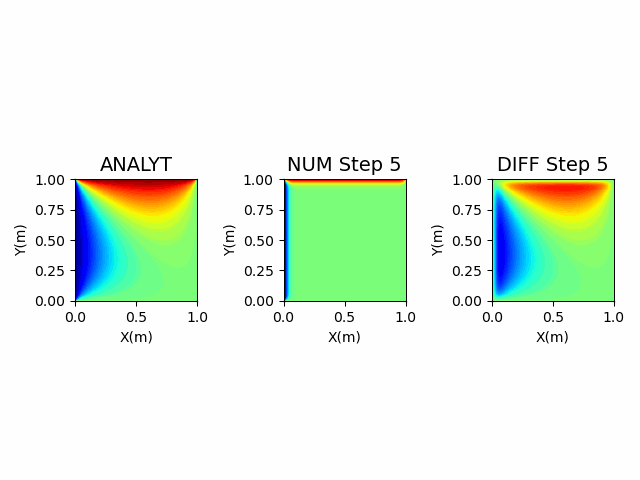

In [9]:
## . . Space axis parameters
nt = 200 # number of iterations
xmin,xmax,ymin,ymax=0,1,0,1
nx,ny=100,100
xx = np.linspace(xmin,xmax,nx)
yy = np.linspace(ymin,ymax,ny)
h = xx[1]-xx[0]

## . . Initialize
U0 = np.zeros((nx,ny))

## . . Boundary Conditions
U0[0   ,:] = 0
U0[:   ,0] = T1
U0[:, -1] = 0
U0[-1, :] = T2

# . . Plotting min/max
vmin,vmax = np.min(T),np.max(T)

## . . Movie solution
c = np.zeros((nx,ny,nt))

## . . Call Solution
for i in range(nt):
    c[:,:,i]=U0
    value = ADI_Solution(U0)
    U0 = value

# . . Compute error
err = np.zeros((nt))
for ii in range(nt):
    x = c[:,:,ii]
    err[ii] = np.linalg.norm(T-x)

# . . Normalize error
err=err/err[0]

## . . Animate Solution
k = 0
kskip=5

## . . Set up movie
fig,ax = plt.subplots(1,3)
fig.subplots_adjust(0,0,1,1)
fig.set_dpi(100)

def Laplace_animate(i):
    global k
    x = c[:,:,k]
    ax[0].imshow(T,cmap='jet', origin="lower", extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax[0].set(xlabel='X(m)', ylabel='Y(m)')
    ax[0].set_title('ANALYT',fontsize=14)
    ax[1].imshow(x ,cmap='jet', origin="lower", extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax[1].set(xlabel='X(m)', ylabel='Y(m)')
    ax[1].set_title('NUM Step %s'%k,fontsize=14)
    ax[2].imshow(T-x ,cmap='jet', origin="lower", extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax[2].set(xlabel='X(m)', ylabel='Y(m)')
    ax[2].set_title('DIFF Step %s'%k,fontsize=14)
    k += kskip
    plt.tight_layout()

## . . Call the animator
ani_filename = 'Ex1.gif'
anim1 = animation.FuncAnimation(fig,
                            Laplace_animate,
                            frames=int((nt-2*kskip)/kskip),
                            interval=100)
anim1.save(ani_filename)
plt.close()

Image(open(ani_filename,'rb').read())

**Q1-3:** Since we know the analytic solution, we can calculate a **convergence plot** illustrating how the error in the numerical solution decreases with the number of solution steps. Do so in the space provided below. This should be similar to Figure 5 in the notes.


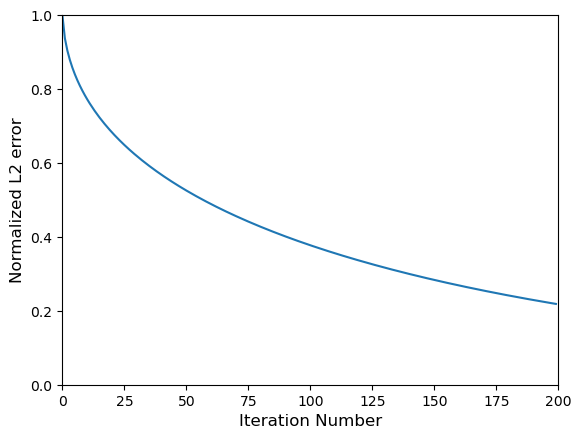

In [11]:
## . . Your answer to Q1-3 goes here
## . . Set up movie
fig2 = plt.figure()
plt.plot(range(nt),err)
plt.ylim(0,1)
plt.xlim(0,nt)
plt.xlabel('Iteration Number',fontsize=12),plt.ylabel('Normalized L2 error',fontsize=12)
plt.show()

**Q1-4:** An important question is **how does the choice of discretization $\Delta xR$ and $\Delta y$ affect the accuracy and convergence rate of the numerical solution**?  Illustrate the difference by redoing the questions **Q1-2** and **Q1-3** above using **double** the number of grid points in both the $x$ and $y$ directions.  Produce one figure illustrating your numerical solution like you did in **Q1-2** and a second figure comparing the convergence rates for your original and modified spatial sampling like in **Q1-3**.

MovieWriter ffmpeg unavailable; using Pillow instead.


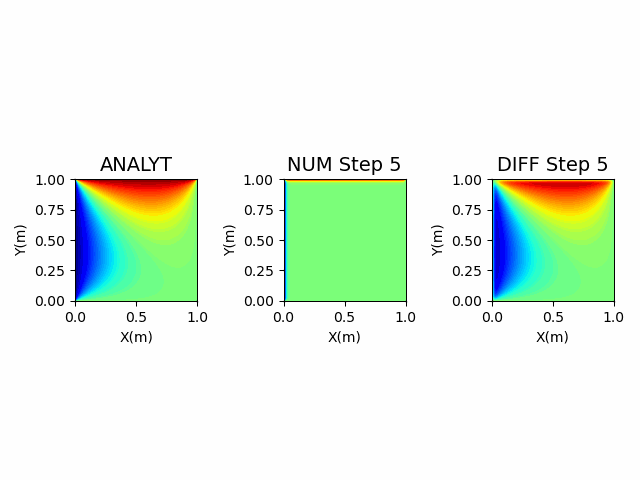

In [13]:
## . . Your answer to Q1-4 goes here
## . . Space axis parameters
nx2,ny2=200,200
xx2 = np.linspace(xmin,xmax,nx2)
yy2 = np.linspace(ymin,ymax,ny2)
h = xx2[1]-xx2[0]

## . . Initialize
U02 = np.zeros((nx2,ny2))

## . . Boundary Conditions
U02[0   ,:] = 0
U02[:   ,0] = T1
U02[:, -1] = 0
U02[-1, :] = T2

# . . True function values
X2, Y2= np.meshgrid(xx2, yy2)
tr2, count= Rect_temp(X2, Y2, T1, T2, a, b, M)

# . . Plotting min/max
vmin,vmax = np.min(tr2),np.max(tr2)

## . . Movie solution
c2 = np.zeros((nx2,ny2,nt))

## . . Call Solution
for i in range(nt):
    c2[:,:,i]=U02
    value = ADI_Solution(U02)
    U02 = value

# . . Compute error
err2 = np.zeros((nt))
for ii in range(nt):
    x = c2[:,:,ii]
    err2[ii] = np.linalg.norm(tr2-x)

# . . Normalize error
err2=err2/err2[0]

## . . Animate Solution
k = 0
kskip=5

## . . Set up movie
fig,ax = plt.subplots(1,3)
fig.subplots_adjust(0,0,1,1)
fig.set_dpi(100)

def Laplace_animate(i):
    global k
    x = c2[:,:,k]
    ax[0].imshow(tr2,cmap='jet',origin="lower", extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax[0].set(xlabel='X(m)', ylabel='Y(m)')
    ax[0].set_title('ANALYT',fontsize=14)
    ax[1].imshow(x ,cmap='jet',origin="lower", extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax[1].set(xlabel='X(m)', ylabel='Y(m)')
    ax[1].set_title('NUM Step %s'%k,fontsize=14)
    ax[2].imshow(tr2-x ,cmap='jet',origin="lower", extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
    ax[2].set(xlabel='X(m)', ylabel='Y(m)')
    ax[2].set_title('DIFF Step %s'%k,fontsize=14)
    k += kskip
    plt.tight_layout()

## . . Call the animator
ani_filename = 'Ex2.gif'
anim1 = animation.FuncAnimation(fig,
                            Laplace_animate,
                            frames=int((nt-2*kskip)/kskip),
                            interval=100)
anim1.save(ani_filename)
plt.close()

Image(open(ani_filename,'rb').read())

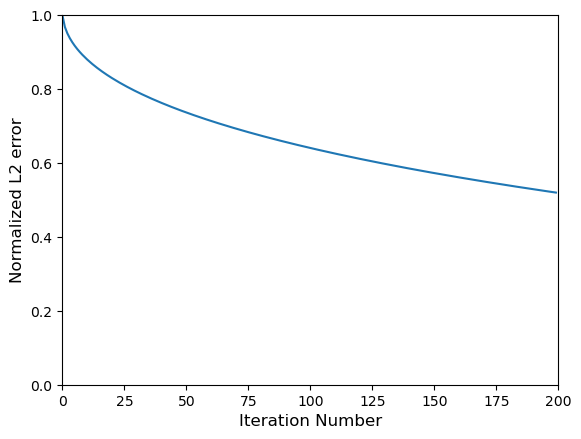

In [14]:
## . . Set up movie
fig2 = plt.figure()
plt.plot(range(nt),err2)
plt.ylim(0,1)
plt.xlim(0,nt)
plt.xlabel('Iteration Number',fontsize=12),plt.ylabel('Normalized L2 error',fontsize=12)
plt.show()

The smaller our discretization the slower our solution converges. This also impacts the accuracy of the numerical solution. Since we are converging slower, the accuracy we reach after the same number of iterations for the larger grid is worse than the accuracy reached for the smaller grid.

## Part 2 - Adding in a heat source

Let's now add some complexity to the physical scenario in Part 1 above.  Let's keep the same experimental set up; however, now we have decided to add a heater element at location $[x,y]=[a/2,b/2]$ (again where $a=b=1$) that outputs heat at constant temperature flux of $200T_2$ per unit area. Also, the size of the heat source is 0.1x0.1. This situation can be modeled solving by Poisson's equation:

$$
\nabla^2 T = F(x,y) \hspace{2cm}
$$
$$
F(x,y)=
\begin{cases}
    200T_2 & \text{if inside heat source}  \\
    0 & \text{if outside heat source}
\end{cases}
\tag{3}
$$

**Q2-1:** Provide an illustration (i.e., animation or series of plots) showing how including this heat source affects the final steady-state solution.  (Note that there is no analytic solution for this problem against which to compare your solution.)


In [17]:
## . . Your solution to Q2-1 goes here
def ADI_Solution_Forcing(U,h,F):
    '''Set up Alternating Direction Solution of Poisson Equation
    usage: U = ADI_Solution(U,h,F)
    input:
        U: starting field
        h: sample interval
        F: Forcing Field
    output:
        U: solution updated in both directions
    dependencies:
        Setup_Tridiagonal
        np.linalg.solve
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''
    ## . . Array dimensions from the input file
    nx,ny = np.size(U,0),np.size(U,1)

    ## . . Allocated dummy array to be used as a temporary solution
    U1 = np.zeros((nx,ny))

    ## . . Force boundary conditions
    U1[:   ,0] = U[:   ,0]
    U1[0   ,:] = U[0   ,:]
    U1[:,ny-1] = U[:,ny-1]
    U1[nx-1,:] = U[nx-1,:]

    ## . . Define tridiagonal matrix in X
    Ax = Setup_Tridiagonal(1, -4, 1, nx)
    bx = np.zeros((nx))

    ## . . Define tridiagonal matrix in Y
    Ay = Setup_Tridiagonal(1, -4, 1, ny)
    by = np.zeros((ny))

    ## . . STEP 1 (solve in the x direction and loop over j - y)
    ## . . Note that we're writing the results to temporary array U1
    for jj in range(1,ny-1):
        bx = -h*h*F[:,jj]-U[:,jj-1]-U[:,jj+1]
        # apply boundary condition
        bx[0] = U[0,jj]
        bx[-1] = U[-1,jj]
        U1[:,jj] = np.linalg.solve(Ax,bx)


    ## . . STEP 2 (solve in the x direction and loop over j - y)
    ## . . Note that we're now rewriting the updated result back to U
    for ii in range(1,nx-1):
        by = -h*h*F[ii,:]-U1[ii-1,:]-U1[ii+1,:]
        # apply boundary condition
        by[0] = U1[ii,0]
        by[-1] = U1[ii,-1]
        U[ii,:] = np.linalg.solve(Ay,by)

    return U

In [18]:
## . . Space axis parameters
nt = 250 # number of iterations
xmin,xmax,ymin,ymax=0,1,0,1
nx,ny=100,100
xx = np.linspace(xmin,xmax,nx)
yy = np.linspace(ymin,ymax,ny)
h = xx[1]-xx[0]

## . . Set up forcing term
dimX=0.1
dimY=0.1
FF = np.zeros((nx,ny))
#get the size of each grid cell
cell_sizeX = a/nx
cell_sizeY= b/ny
#get the index of [x,y]=[a/2, b/2], assuming 0<x<a & 0<y<b (VERY IMPORTANT)
idx_x= int(nx/2)
idx_y= int(ny/2)
#number of grid cells that heat source covers
cellsX= int(dimX/cell_sizeX)
cellsY= int(dimY/cell_sizeY)
#set heat source
for i in range(int(-cellsX/2), int(cellsX/2 + 1)):
    for j in range(int(-cellsY/2), int(cellsY/2 + 1)):
        if (0 <= idx_x + i < nx) and (0 <= idx_y + j < ny):
            FF[idx_x + i, idx_y + j] = 200*T2  # Set heat value
# plt.imshow(FF,cmap='jet', origin="lower", extent=[xmin,xmax,ymin,ymax],vmin=vmin,vmax=vmax)
# print(FF[45:55,45:55]) # check that the right points have been assigned 200T2

## . . Initialize solution
U0 = np.zeros((nx,ny)) # . . Note boundary conditions are set as well
## . . Boundary Conditions
U0[0   ,:] = 0
U0[:   ,0] = T1
U0[:, -1] = 0
U0[-1, :] = T2

# . . Plotting min/max
vmin,vmax = 0,1

## . . Movie solution
e = np.zeros((nx,ny,nt))
conv = np.zeros((nt)) # . . For convergence

## . . Call Solution
for i in range(nt):
    e[:,:,i]=U0
    value = ADI_Solution_Forcing(U0,h,FF)
    U0 = value
    conv[i] = np.linalg.norm(e[:,:,i]-U0)  ## . . Let's examine the convergence
conv=conv/conv[0] ## . . Normalize

MovieWriter ffmpeg unavailable; using Pillow instead.


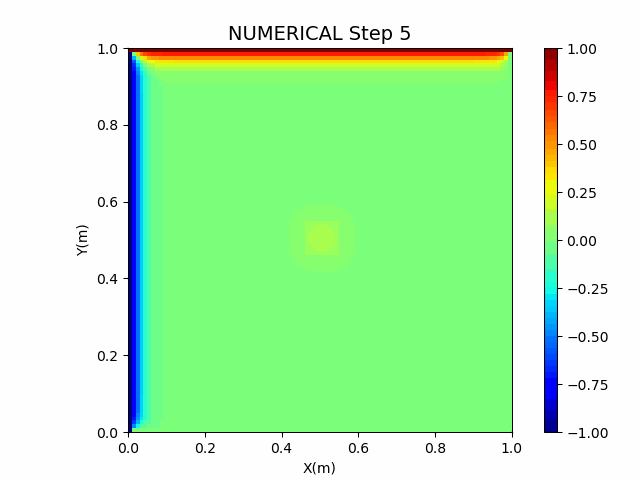

In [19]:
k = 0
kskip=5
## . . Set up movie
fig3,ax3 = plt.subplots()
fig3.subplots_adjust(0.1,0.1,0.9,0.9)
fig3.set_dpi(100)

x = e[:,:,k]
imax = ax3.imshow(x,cmap='jet',extent=[xmin,xmax,ymin,ymax])
cbar_ax = fig3.add_axes([0.85,0.1,0.02,0.8])
# fig3.colorbar(imax,ax=cbar_ax)

def Poisson_animate(i):
    global k
    x = e[:,:,k]
    cbar_ax.cla()
    imax = ax3.imshow(x,cmap='jet', origin= "lower", extent=[xmin,xmax,ymin,ymax])
    ax3.set(xlabel='X(m)', ylabel='Y(m)')
    ax3.set_title('NUMERICAL Step %s'%k,fontsize=14)
    fig3.colorbar(imax,cax=cbar_ax)
    k += kskip

## . . Call the animator
ani_filename = 'Ex4.gif'
anim2 = animation.FuncAnimation(fig3,Poisson_animate,frames=int((nt-2*kskip)/kskip),interval=100)
anim2.save(ani_filename)
plt.close()

Image(open(ani_filename,'rb').read())

**Q2-2:** Add a plot showing the convergence similar to that shown in Figure 7 of the notebook.

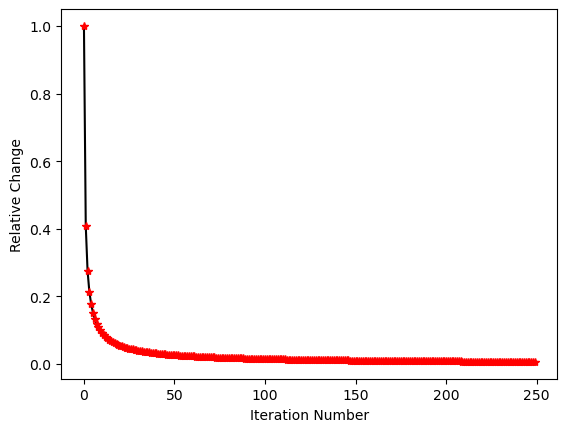

In [21]:
## . . Your solution to Q2-2 goes here
plt.figure()
plt.plot(range(nt),conv,'k',range(nt),conv,'r*')
plt.xlabel('Iteration Number'); plt.ylabel('Relative Change')
plt.show()

## Part 3 - Adding in Spatially Varying Thermal Conductivity

You now have a situation where the medium inside the rectangle has a thermal conductivity $K(x,y)$ is given by:

$$K(x,y) = 1-0.75 {\rm e}^{- \left(x-\frac{a}{2}\right)^2-\left(y-\frac{b}{2}\right)^2} \tag{4}$$

**Q3-1:** Extend the example from Part 2 (i.e., with the heat source) to include the above spatially varying thermal conductivity.  This will require solving the following elliptical PDE:

$$
\nabla \cdot \left(K \nabla T\right) =
\begin{cases}
    200T_2 & \text{if inside heat source}  \\
    0 & \text{if outside heat source}
\end{cases}
\tag{5}
$$

Provide an illustration (i.e., animation or series of plots) showing how the inclusion of both the spatially varying thermal conductivity and heat source terms affect the final steady-state solution.


In [23]:
## . . Your answer to Q3-1 goes here
def Setup_Tridiagonal_Heterogeneous(a,b,c,n):
    A = np.diag(a, -1) + np.diag(b, 0) + np.diag(c, 1)
    A[0,0] = 1
    A[0,1] = 0
    A[-1,-1] = 1
    A[-1,-2] = 0
    return A
def ADI_Solution_Heterogeneous(U,K, F):
    nx,ny = np.size(U,0),np.size(U,1)
    U1    = np.zeros((nx,ny))

    ## . . Force boundary conditions
    U1[:   ,0] = U[:   ,0]
    U1[0   ,:] = U[0   ,:]
    U1[:,ny-1] = U[:,ny-1]
    U1[nx-1,:] = U[nx-1,:]

    ## . . Coefficients for x
    axmat = np.zeros((nx-1))
    bxmat = np.zeros((nx  ))
    cxmat = np.zeros((nx-1))
    bx    = np.zeros((nx  ))

    ## . . Coefficients for x
    aymat = np.zeros((ny-1))
    bymat = np.zeros((ny  ))
    cymat = np.zeros((ny-1))
    by    = np.zeros((ny  ))

    ## . . Loop over j (y)
    for jj in range(1,ny-1):

        axmat = K[0:nx-1,jj]
        bxmat = -2.*K[:,jj]-K[:,jj-1]-np.insert(K[0:nx-1,jj],0,0)
        cxmat = K[1:nx  ,jj]

        ## . . have to set this up each time b/c is heterogeneous now
        Ax = Setup_Tridiagonal_Heterogeneous(axmat,bxmat,cxmat,nx)
        bx = -np.multiply(K[:,jj],U[:,jj+1]) - np.multiply(K[:,jj-1],U[:,jj-1]) - h*h*F[:,jj]

        # force boundary condition
        bx[0] = U[0,jj]
        bx[-1] = U[-1,jj]

        U1[:,jj] = np.linalg.solve(Ax,bx)


    ## . . Loop over i (x)
    for ii in range(1,nx-1):
        aymat =     K[ii,0:ny-1]
        bymat = -2.*K[ii,:     ]-K[ii-1,:]-np.insert(K[ii,0:ny-1],0,0)
        cymat =     K[ii,1:ny  ]

        ## . . have to set this up each time b/c is heterogeneous now
        Ay = Setup_Tridiagonal_Heterogeneous(aymat,bymat,cymat,ny)
        by = -np.multiply(K[ii,:],U1[ii+1,:]) - np.multiply(K[ii-1,:],U1[ii-1,:]) - h*h*F[ii,:]

        by[0] = U1[ii,0]
        by[-1] = U1[ii,-1]

        U[ii,:] = np.linalg.solve(Ay,by)

    return U


MovieWriter ffmpeg unavailable; using Pillow instead.


The total execution time for python: 0.016005754470825195 s


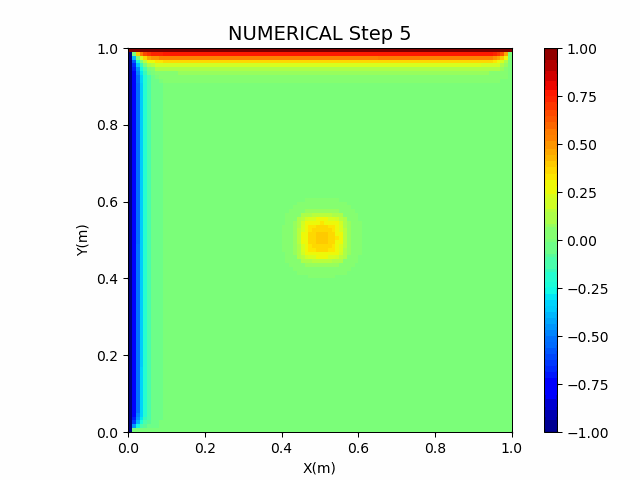

In [24]:
## . . Space axis parameters
nt = 250 # number of iterations
xmin,xmax,ymin,ymax=0,a,0,b
nx,ny=100,100
xx = np.linspace(xmin,xmax,nx)
yy = np.linspace(ymin,ymax,ny)
h = xx[1]-xx[0]

## . . Initialize
U0 = np.zeros((nx,ny))

## . . Boundary Conditions
U0[0   ,:] = 0
U0[:   ,0] = T1
U0[:, -1] = 0
U0[-1, :] = T2
# . . Plotting min/max
vmin,vmax =0,1

## . . Set up forcing term
dimX=0.1
dimY=0.1
F = np.zeros((nx,ny))
#get the size of each grid cell
cell_sizeX = a/nx
cell_sizeY= b/ny
#get the index of [x,y]=[a/2, b/2], assuming 0<x<a & 0<y<b (VERY IMPORTANT)
idx_x= int(nx/2)
idx_y= int(ny/2)
#number of grid cells that heat source covers
cellsX= int(dimX/cell_sizeX)
cellsY= int(dimY/cell_sizeY)
#set heat source
for i in range(int(-cellsX/2), int(cellsX/2 + 1)):
    for j in range(int(-cellsY/2), int(cellsY/2 + 1)):
        if (0 <= idx_x + i < nx) and (0 <= idx_y + j < ny):
            F[idx_x + i, idx_y + j] = 200*T2  # Set heat value

## . . Heterogeneous solution
xxx, yyy = np.meshgrid(xx, yy, sparse=True)
K = np.zeros((nx,ny))+1 - 0.75*np.exp(-(xxx-(a/2))**2 - (yyy-(b/2))**2)
Kmin,Kmax = np.min(K),np.max(K)

## . . Movie solution
f = np.zeros((nx,ny,nt))

## . . Call Solution
for i in range(nt):
    f[:,:,i]=U0
    timeStart=time()
    value = ADI_Solution_Heterogeneous(U0,K, F)
    timeEnd=time()
    U0 = value
print("The total execution time for python:", timeEnd-timeStart, "s")
## . . Animate Solution and compute error
k = 0
kskip = 5

## . . Set up movie
fig5,ax5 = plt.subplots()
fig5.subplots_adjust(0.1,0.1,0.9,0.9)
fig5.set_dpi(100)

x = f[:,:,k]
imax = ax5.imshow(x,cmap='jet',extent=[xmin,xmax,ymin,ymax])
cbar_ax = fig5.add_axes([0.85,0.1,0.02,0.8])
# fig3.colorbar(imax,ax=cbar_ax)

def Laplace_heterogeneous_animate(i):
    global k
    x = f[:,:,k]
    cbar_ax.cla()
    imax = ax5.imshow(x,cmap='jet', origin= "lower", extent=[xmin,xmax,ymin,ymax])
    ax5.set(xlabel='X(m)', ylabel='Y(m)')
    ax5.set_title('NUMERICAL Step %s'%k,fontsize=14)
    fig5.colorbar(imax,cax=cbar_ax)
    k += kskip


## . . Call the animator
ani_filename = 'Ex5.gif'
anim4 = animation.FuncAnimation(fig5,Laplace_heterogeneous_animate,frames=int((nt-2*kskip)/kskip),interval=100)
anim4.save(ani_filename)
plt.close()

Image(open(ani_filename,'rb').read())

# Part 4 (GPGN536 Only) - Convert Part 3 into C, compare the results and computational performance with Python

In [40]:
## . . Your answer to Q4-1 goes here
%%writefile ADIHetero_c.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>

#define MIN(a,b) (((a)<(b))?(a):(b))
#define MAX(a,b) (((a)>(b))?(a):(b))

void Setup_Tridiagonal_Heterogeneous(double *a, double *b, double *c, int n, double **A) {
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            if (i == j) A[i][j] = b[i];
            else if (i == j + 1) A[i][j] = a[i-1];
            else if (i == j - 1) A[i][j] = c[i];
            else A[i][j] = 0;
        }
    }
    A[0][0] = 1;
    A[0][1] = 0;
    A[n-1][n-1] = 1;
    A[n-1][n-2] = 0;
}

double** ADI_Solution_Heterogeneous(double **U, double **K, double **F, int nx, int ny, double h) {
    double **U1 = (double **)malloc(nx * sizeof(double *));
    for (int i = 0; i < nx; i++) {
        U1[i] = (double *)malloc(ny * sizeof(double));
    }

    for (int i = 0; i < nx; i++) {
        U1[i][0] = U[i][0];
        U1[i][ny-1] = U[i][ny-1];
    }
    for (int j = 0; j < ny; j++) {
        U1[0][j] = U[0][j];
        U1[nx-1][j] = U[nx-1][j];
    }

    double *axmat = (double *)malloc((nx-1) * sizeof(double));
    double *bxmat = (double *)malloc(nx * sizeof(double));
    double *cxmat = (double *)malloc((nx-1) * sizeof(double));
    double *bx = (double *)malloc(nx * sizeof(double));

    double *aymat = (double *)malloc((ny-1) * sizeof(double));
    double *bymat = (double *)malloc(ny * sizeof(double));
    double *cymat = (double *)malloc((ny-1) * sizeof(double));
    double *by = (double *)malloc(ny * sizeof(double));

    double **Ax = (double **)malloc(nx * sizeof(double *));
    for (int i = 0; i < nx; i++) {
        Ax[i] = (double *)malloc(nx * sizeof(double));
    }

    double **Ay = (double **)malloc(ny * sizeof(double *));
    for (int i = 0; i < ny; i++) {
        Ay[i] = (double *)malloc(ny * sizeof(double));
    }

    for (int jj = 1; jj < ny-1; jj++) {
        for (int i = 0; i < nx-1; i++) {
            axmat[i] = K[i][jj];
        }
        for (int i = 0; i < nx; i++) {
            bxmat[i] = -2*K[i][jj] - K[i][jj-1] - (i > 0 ? K[i-1][jj] : 0);
        }
        for (int i = 1; i < nx; i++) {
            cxmat[i-1] = K[i][jj];
        }

        Setup_Tridiagonal_Heterogeneous(axmat, bxmat, cxmat, nx, Ax);

        for (int i = 0; i < nx; i++) {
            bx[i] = -K[i][jj]*U[i][jj+1] - K[i][jj-1]*U[i][jj-1] - h*h*F[i][jj];
        }

        bx[0] = U[0][jj];
        bx[nx-1] = U[nx-1][jj];

        // Solve Ax * U1[:,jj] = bx
        // This is a simplified solver and may not be as efficient as specialized tridiagonal solvers
        for (int i = 1; i < nx; i++) {
            double m = Ax[i][i-1] / Ax[i-1][i-1];
            Ax[i][i] -= m * Ax[i-1][i];
            bx[i] -= m * bx[i-1];
        }
        U1[nx-1][jj] = bx[nx-1] / Ax[nx-1][nx-1];
        for (int i = nx-2; i >= 0; i--) {
            U1[i][jj] = (bx[i] - Ax[i][i+1] * U1[i+1][jj]) / Ax[i][i];
        }
    }

    for (int ii = 1; ii < nx-1; ii++) {
        for (int j = 0; j < ny-1; j++) {
            aymat[j] = K[ii][j];
        }
        for (int j = 0; j < ny; j++) {
            bymat[j] = -2*K[ii][j] - K[ii-1][j] - (j > 0 ? K[ii][j-1] : 0);
        }
        for (int j = 1; j < ny; j++) {
            cymat[j-1] = K[ii][j];
        }

        Setup_Tridiagonal_Heterogeneous(aymat, bymat, cymat, ny, Ay);

        for (int j = 0; j < ny; j++) {
            by[j] = -K[ii][j]*U1[ii+1][j] - K[ii-1][j]*U1[ii-1][j] - h*h*F[ii][j];
        }

        by[0] = U1[ii][0];
        by[ny-1] = U1[ii][ny-1];

        // Solve Ay * U[ii,:] = by
        // This is a simplified solver and may not be as efficient as specialized tridiagonal solvers
        for (int j = 1; j < ny; j++) {
            double m = Ay[j][j-1] / Ay[j-1][j-1];
            Ay[j][j] -= m * Ay[j-1][j];
            by[j] -= m * by[j-1];
        }
        U[ii][ny-1] = by[ny-1] / Ay[ny-1][ny-1];
        for (int j = ny-2; j >= 0; j--) {
            U[ii][j] = (by[j] - Ay[j][j+1] * U[ii][j+1]) / Ay[j][j];
        }
    }

    for (int i = 0; i < nx; i++) {
        free(U1[i]);
    }
    free(U1);
    free(axmat);
    free(bxmat);
    free(cxmat);
    free(bx);
    free(aymat);
    free(bymat);
    free(cymat);
    free(by);
    for (int i = 0; i < nx; i++) {
        free(Ax[i]);
    }
    free(Ax);
    for (int i = 0; i < ny; i++) {
        free(Ay[i]);
    }
    free(Ay);
    return U;
}

int main() {
    int nt = 250;
    double a = 1.0, b = 1.0;  // Assuming a and b are 1.0, adjust as needed
    int nx = 100, ny = 100;
    double xmin = 0, xmax = a, ymin = 0, ymax = b;
    double T1 = -1.0, T2 = 1.0;  // Assuming T1 and T2, adjust as needed

    double h = (xmax - xmin) / (nx - 1);

    double **U0 = (double **)malloc(nx * sizeof(double *));
    double **K = (double **)malloc(nx * sizeof(double *));
    double **F = (double **)malloc(nx * sizeof(double *));
    for (int i = 0; i < nx; i++) {
        U0[i] = (double *)calloc(ny, sizeof(double));
        K[i] = (double *)malloc(ny * sizeof(double));
        F[i] = (double *)calloc(ny, sizeof(double));
    }

    for (int j = 0; j < ny; j++) {
        U0[0][j] = T1;
        U0[nx-1][j] = 0;
    }
    for (int i = 0; i < nx; i++) {
        U0[i][0] = T2;
        U0[i][ny-1] = 0;
    }

    double dimX = 0.1, dimY = 0.1;
    double cell_sizeX = a / nx;
    double cell_sizeY = b / ny;
    int idx_x = nx / 2;
    int idx_y = ny / 2;
    int cellsX = (int)(dimX / cell_sizeX);
    int cellsY = (int)(dimY / cell_sizeY);

    for (int i = -cellsX/2; i <= cellsX/2; i++) {
        for (int j = -cellsY/2; j <= cellsY/2; j++) {
            if (idx_x + i >= 0 && idx_x + i < nx && idx_y + j >= 0 && idx_y + j < ny) {
                F[idx_x + i][idx_y + j] = 200 * T2;
            }
        }
    }

    for (int i = 0; i < nx; i++) {
        double x = xmin + i * h;
        for (int j = 0; j < ny; j++) {
            double y = ymin + j * h;
            K[i][j] = 1 - 0.75 * exp(-pow(x - 0.5, 2) - pow(y - 0.5, 2));
        }
    }
        double*** f = malloc(nx * sizeof(double**));
    for (int i = 0; i < nx; i++) {
        f[i] = malloc(ny * sizeof(double*));
        for (int j = 0; j < ny; j++) {
            f[i][j] = malloc(nt * sizeof(double));
        }
    }

    FILE *file = fopen("output.txt", "w");
    if (file == NULL) {
        perror("Error opening file");
        return -1;
    }

    clock_t start, end;
    double cpu_time_used;

    for (int i = 0; i < nt; i++) {
        for (int x = 0; x < nx; x++) {
            for (int y = 0; y < ny; y++) {
                f[x][y][i] = U0[x][y];
            }
        }
        start = clock();
        double** value = ADI_Solution_Heterogeneous(U0, K, F, nx, ny, h );
        end = clock();
        cpu_time_used = ((double) (end - start)) / CLOCKS_PER_SEC;
        U0 = value;
    }
    for (int x = 0; x < nx; x++) {
        for (int y = 0; y < ny; y++) {
            fprintf(file, "%lf ", U0[x][y]); // Print each value in U0
        }
        fprintf(file, "\n"); // New line after each row
   }


    printf("The total execution time for C: %f s\n", cpu_time_used);
    for (int i = 0; i < nx; i++) {
        free(U0[i]);
        free(K[i]);
        free(F[i]);
    }
    free(U0);
    free(K);
    free(F);

    return 0;
}

SyntaxError: invalid syntax (2153624208.py, line 12)

In [151]:
%%shell
gcc -o ADIHetero_c ADIHetero_c.c -lm
./ADIHetero_c

The total execution time for C: 0.007726 s


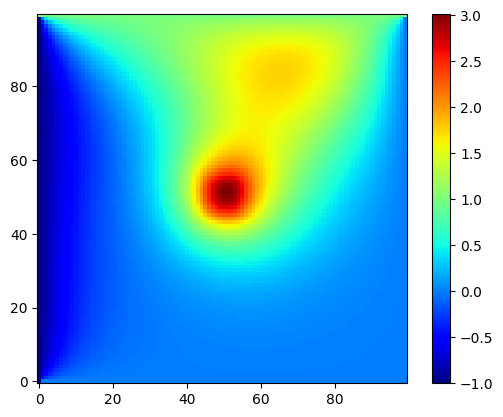

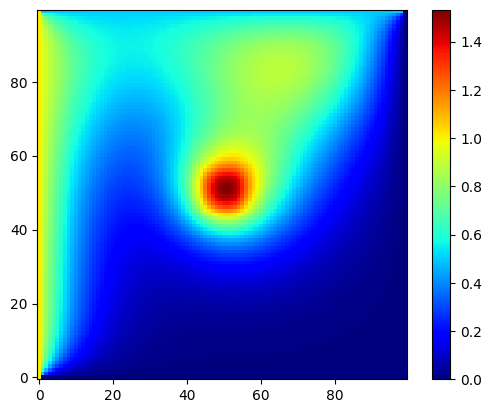

In [152]:
filename= "output.txt"
with open(filename, 'r') as file:
    data = file.readlines()
    u0_array = []
    # Loop through each line in the file and parse the values
    for line in data:
        # Convert line into float values and append to u0_array
        if line.strip():  # Skip empty lines
            u0_array.append([float(value) for value in line.split()])

plt.imshow(U0, cmap="jet", origin="lower")
plt.colorbar()
plt.show()
plt.imshow(C_val, cmap="jet", origin="lower")
plt.colorbar()
plt.show()

It is not quite the same solution, but this was very difficult to translate to C because anytime I tried translate the defintions and then translate the main function, there is inconsistencies between function calss. However, if I try to translate it all together I break the AI model.

Overall, the C is faster, as expected.